## Advanced lane detection
Purpose of this project is to detect a variety of lane lines reliably under different lighting conditions. I'll apply tecniques that I learned in the Udacity Self-Driving car nanodegree program. These tecniques are still classical computer vision tecniques and we don't resort any sort of Deep Learning solution.

Pipeline of the project is as follows:
1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.


#### Finding calibration rig corners

In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

visualize_results = 0 

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        if visualize_results:
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #write_name = 'corners_found'+str(idx)+'.jpg'
            #cv2.imwrite(write_name, img)
            cv2.imshow('img', img)
            cv2.waitKey(500)

cv2.destroyAllWindows()

#### Testing calibration parameters

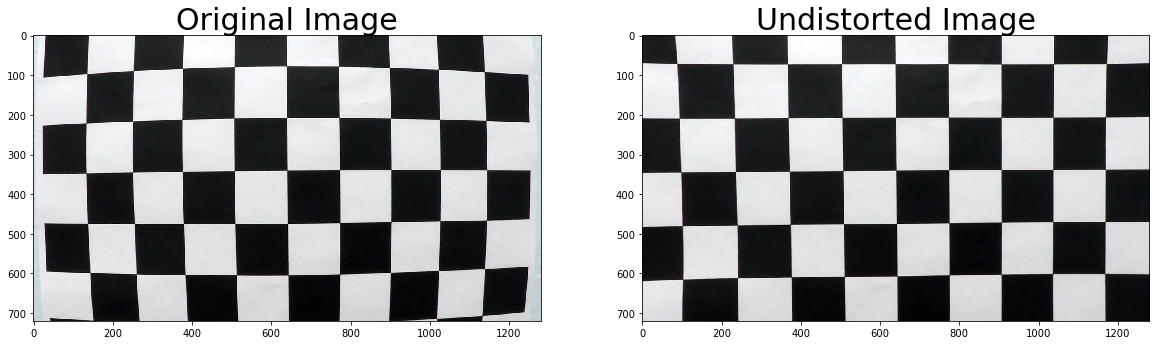

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
#cv2.imwrite('output_images/undistort_input.jpg',img)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
#cv2.imwrite('output_images/undistort_output.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### Apply a distortion correction to raw images.


In [3]:
def correct_distortion(img, mtx, dist):
    """Corrects distortion based on 
    given calibration parameters"""
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

#### Test it

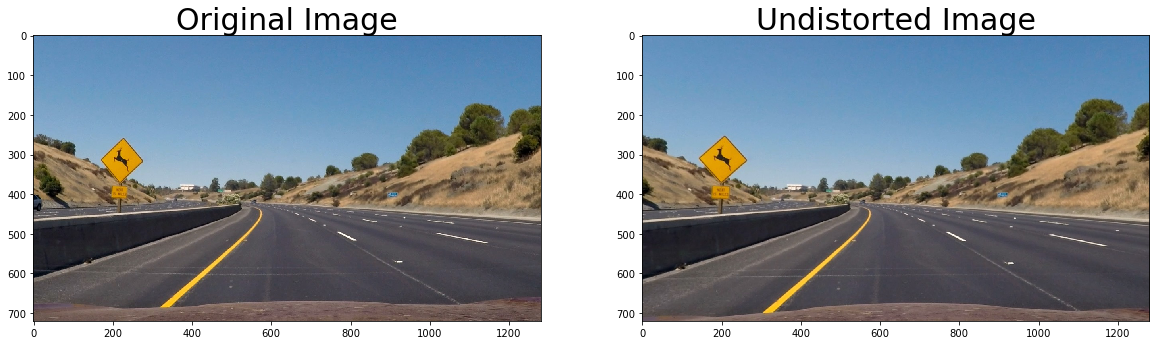

In [5]:
dist_pickle = pickle.load( open( "camera_cal/dist_pickle.p", "rb" ) )
mtx_test = dist_pickle["mtx"]
dist_test = dist_pickle["dist"]

img_test = cv2.imread('test_images/test2.jpg')
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)

undist_test = correct_distortion(img_test, mtx_test, dist_test)
#v2.imwrite('output_images/img_undistorted.jpg',undist_test)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_test)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_test)
ax2.set_title('Undistorted Image', fontsize=30)

### Use color transforms, gradients, etc., to create a thresholded binary image.


In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    gray = img
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = img
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = img
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def smart_thres(image, visualize_results = False):
    """Applies color transforms, gradient thresholding to create
    binarized image"""
    
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    
    # Choose a Sobel kernel size
    ksize = 5 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    #gradx = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    #grady = abs_sobel_thresh(s_channel, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(s_channel, sobel_kernel=ksize, mag_thresh=(10, 100))
    dir_binary = dir_threshold(s_channel, sobel_kernel=ksize, thresh=(0, 0.5))
    hls_binary = hls_select(image, thresh=(150, 255))

    combined = np.zeros_like(dir_binary)
    combined[((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 255
    #combined[(hls_binary == 1)] = 1
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1
    
    
    #visualize thresholding results
    if visualize_results :
        f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20,10))
        ax1.imshow(gradx, cmap='gray')
        ax2.imshow(grady, cmap='gray')
        ax3.imshow(mag_binary, cmap='gray')
        ax4.imshow(dir_binary, cmap='gray')
        ax5.imshow(hls_binary, cmap='gray')
        ax6.imshow(combined, cmap='gray')
    
    
    return combined


#### Test thresholding

In [7]:
img_test = cv2.imread('test_images/test2.jpg')

thres_img = smart_thres(img_test, False)

#cv2.imwrite('output_images/thres_combined.jpg',thres_img)


### Apply a perspective transform to rectify binary image ("birds-eye view").


#### Determine perspective tfm coordinates

Using matplotlib backend: Qt5Agg


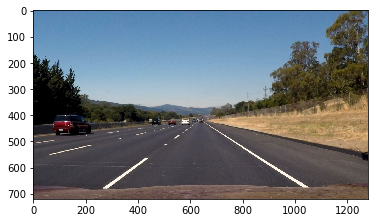

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib

img_tfm_test = mpimg.imread('test_images/straight_lines2.jpg')
plt.imshow(img_tfm_test)

In [17]:
def get_birdseye(img, mtx, dist, offset = 100, visualize = False):
    """Applies perspective transformation to get 
    bird's eye view of the road surface"""
    
    #corner_tl = [622, 430]
    #corner_tr = [658, 430]
    corner_tl = [573, 468]
    corner_tr = [714, 468]
    corner_bl = [278, 670]
    corner_br = [1036, 670]
    
    img_undist = correct_distortion(img, mtx, dist)
    
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32([corner_tl, corner_tr, corner_br, corner_bl])

    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], 
                                 [img_size[0]-offset, img_size[1]-0], 
                                 [offset, img_size[1]-0]])
    
    if(visualize == True):
        img_undist = cv2.line(img_undist,tuple(corner_tl),tuple(corner_tr),(255,0,0),2)
        img_undist = cv2.line(img_undist,tuple(corner_tr),tuple(corner_br),(255,0,0),2)
        img_undist = cv2.line(img_undist,tuple(corner_br),tuple(corner_bl),(255,0,0),2)
        img_undist = cv2.line(img_undist,tuple(corner_bl),tuple(corner_tl),(255,0,0),2)
        
        cv2.imwrite('output_images/tfm_input.jpg',img_undist)

    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    img_warped = cv2.warpPerspective(img_undist, M, img_size)
    
    if(visualize == True):
        cv2.imwrite('output_images/tfm_output.jpg',img_warped)
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img_undist)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(img_warped)
        ax2.set_title('Undistorted Image', fontsize=30)

    # Return the resulting image and matrix
    return img_warped, M

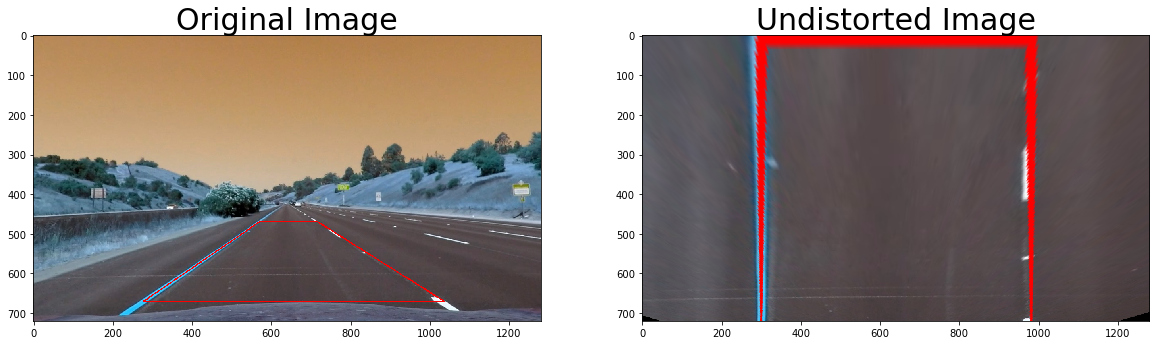

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_tfm_test = cv2.imread('test_images/straight_lines1.jpg')
cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_tfm_output, M = get_birdseye(img_tfm_test, mtx, dist, offset = 300, visualize = True)




### Detect lane pixels and fit to find the lane boundary.


In [11]:
from numpy.linalg import norm

class Line():
    def __init__(self):
        self.nr_elems = 50
        self.xdim = 1280
        self.ydim = 720
        self.detection_age = 0
        self.y_pix_fit = np.linspace(0, self.ydim-1, self.ydim )
        self.x_pix_fit = None
        
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = np.empty(shape = (0,self.ydim))  
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
    
    def get_curv(self, fit_curv_current):

        return ((1 + (2*fit_curv_current[0]*self.ydim*self.ym_per_pix + \
                      fit_curv_current[1])**2)**1.5) / np.absolute(2*fit_curv_current[0])
            
    def get_lane_pos(self, fit_coeffs):
        
        return fit_coeffs[0]*self.ydim**2 + fit_coeffs[1]*self.ydim + fit_coeffs[2]
        
    def reset_tracker(self):
        self.recent_xfitted = np.empty(shape=(0,self.ydim))
        self.detection_age = 0
        self.detected = False

        
    def add_measurement(self, x_pix, y_pix):
        
        if(len(x_pix) == 0):
            return
        
        # Fit a second order polynomial to each
        self.current_fit = np.polyfit(y_pix, x_pix, 2)
        fit_curv_current  = np.polyfit(y_pix*self.ym_per_pix, x_pix*self.xm_per_pix, 2)
        curv_current = self.get_curv(fit_curv_current)
        
        self.x_pix_fit = self.current_fit[0]*self.y_pix_fit**2 + self.current_fit[1]*self.y_pix_fit + self.current_fit[2]
        
        if len(self.recent_xfitted) > 0:
            
            fit_diff = sum(self.bestx - self.x_pix_fit)/len(self.bestx)
            
            if fit_diff > 50:
                self.detection_age = self.detection_age + 1
                
                if(self.detection_age > 10):
                    self.reset_tracker()
                return
        
        self.detection_age = 0
        self.detected = True                  
        self.recent_xfitted = np.vstack((self.recent_xfitted,self.x_pix_fit))
        if len(self.recent_xfitted) > self.nr_elems:
            self.recent_xfitted = np.delete(self.recent_xfitted,0,0)
            
        self.bestx = sum(self.recent_xfitted)/len(self.recent_xfitted)  
        self.best_fit = np.polyfit(self.y_pix_fit, self.bestx, 2)
        fit_curv_best  = np.polyfit(self.y_pix_fit*self.ym_per_pix, self.bestx*self.xm_per_pix, 2)
        self.radius_of_curvature = self.get_curv(fit_curv_best)
        self.line_base_pos = self.get_lane_pos(self.best_fit)
    

In [12]:
def find_lanes(binary_warped, left_line, right_line):
    
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
        
    if(left_line.detected == False):
            # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        left_lane_inds = np.concatenate(left_lane_inds)
    else:
        left_lane_inds = ((nonzerox > (left_line.best_fit[0]*(nonzeroy**2) + \
                                       left_line.best_fit[1]*nonzeroy + left_line.best_fit[2] - margin)) & \
                          (nonzerox < (left_line.best_fit[0]*(nonzeroy**2) + \
                                       left_line.best_fit[1]*nonzeroy + left_line.best_fit[2] + margin))) 

    if(right_line.detected == False):
            # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height

            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Identify the nonzero pixels in x and y within the window
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        right_lane_inds = np.concatenate(right_lane_inds)

            
    else:
        right_lane_inds = ((nonzerox > (right_line.best_fit[0]*(nonzeroy**2) + \
                                        right_line.best_fit[1]*nonzeroy + right_line.best_fit[2] - margin)) & \
                           (nonzerox < (right_line.best_fit[0]*(nonzeroy**2) + \
                                        right_line.best_fit[1]*nonzeroy + right_line.best_fit[2] + margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    left_line.add_measurement(leftx, lefty)
    right_line.add_measurement(rightx, righty)


    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0,255]
        
    
    lane_offset = left_line.xm_per_pix * (binary_warped.shape[1]/2.0 - (left_line.line_base_pos + right_line.line_base_pos)/2)
    return left_line.best_fit, right_line.best_fit, \
           left_line.radius_of_curvature, right_line.radius_of_curvature, \
           lane_offset, out_img



#### Test detection

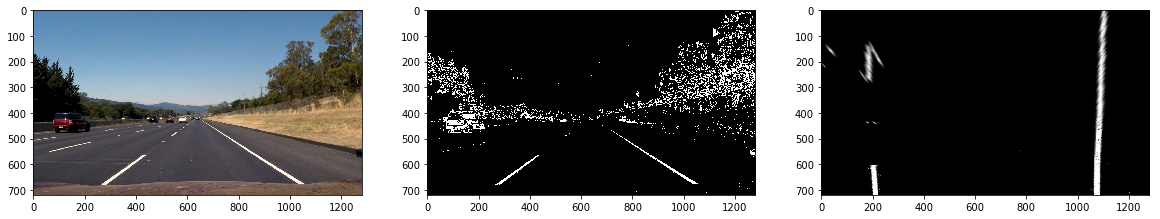

In [13]:
#test
%matplotlib inline

#img_test = mpimg.imread('test_images/straight_lines2.jpg')
img_test = cv2.imread('test_images/straight_lines2.jpg')
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)

img_test_thres = smart_thres(img_test)

img_warped, M = get_birdseye(img_test_thres, mtx, dist, offset=200)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(img_test)
ax2.imshow(img_test_thres, cmap='gray')
ax3.imshow(img_warped, cmap='gray')
        

In [ ]:
left_fit, right_fit, left_curv, right_curv, lateral_offset, lane_img = find_lanes(img_warped, left_line, right_line)

### Determine the curvature of the lane and vehicle position with respect to center.


### Warp the detected lane boundaries back onto the original image.


In [14]:
from numpy.linalg import inv

def warp_back(warped, org_img, Minv, left_fit, right_fit):
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    # Create an image to draw the lines on
    #warp_zero = np.zeros_like(warped).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    color_warp = (warped*255).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (org_img.shape[1], org_img.shape[0])) 
    # Combine the result with the original image
    
    result = cv2.addWeighted(org_img, 1.0, newwarp, .5, 0)
    #plt.imshow(result)
    
    return result


    


### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [15]:
def overlay_info(img, left_curv, right_curv, lateral_offset):
    cv2.putText(img, "Curvature: {0:5d} m".format(int((left_curv+right_curv)/2)), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(img, "Lateral position: {0:3.2f} m".format(lateral_offset), (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2,cv2.LINE_AA)

    #plt.imshow(img)
    
    return img
    
#warped_back = warp_back(lane_img, img_test, inv(M), left_fit, right_fit)
#overlay_info(warped_back, left_curv, right_curv, lateral_offset)


### Test on videos

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle

dist_pickle = pickle.load( open( "camera_cal/dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

left_line = Line()
right_line = Line()
                        

def process_image(image):
    global left_line, right_line
    
    
    img_warped, M = get_birdseye(image, mtx, dist, offset=200)

    image_thres = smart_thres(img_warped, False)
    
    #plt.imshow(image_thres)
    
    left_fit, right_fit, left_curv, right_curv, lateral_offset, lane_img = find_lanes(image_thres, left_line, right_line)
        
    #cv2.imwrite('output_images/lane_pixels.jpg',lane_img)
    
    warped_back = warp_back(lane_img, image, inv(M), left_fit, right_fit)
    overlay_img = overlay_info(warped_back, left_curv, right_curv, lateral_offset)

    return overlay_img


clip1_output_path = 'output_images/project_video.mp4'
#clip1_video = VideoFileClip("project_video.mp4").subclip(40,50)
clip1_video = VideoFileClip("project_video.mp4")

clip1_process = clip1_video.fl_image(process_image)
%time clip1_process.write_videofile(clip1_output_path, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 250/251 [00:56<00:00,  4.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 3min 29s, sys: 42 s, total: 4min 11s
Wall time: 56.8 s


#### Test individual image

In [ ]:
img_test = cv2.imread('test_images/test2.jpg')
#img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)

output = process_image(img_test)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_test)
ax2.imshow(output, cmap='gray')

#cv2.imwrite('output_images/final_image.jpg',output)